## **Preprocessing and Modeling**

- Is text data successfully converted to a matrix representation?
- Are methods such as stop words, stemming, and lemmatization explored?
- Does the student properly split and/or sample the data for validation/training purposes?
- Does the student test and evaluate a variety of models to identify a production algorithm (**AT MINIMUM:** two models)?
- Does the student defend their choice of production model relevant to the data at hand and the problem?
- Does the student explain how the model works and evaluate its performance successes/downfalls?

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk


from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score


from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


from sklearn.metrics import confusion_matrix


In [157]:
marvel =pd.read_csv('marvel.csv')
harrypotter=pd.read_csv('harrypotter.csv')

In [158]:
marvel.head()

,id,title,content,score,num_comments,author,created_utc,upvote_ratio,subreddit_flair,submission_datetime,post_type,entity_recognition,text_sentiment,external_links_count
0,yktbuk,We need more scenes like this,NaN,46807,1188,steikul,1.667453e+09,0.91,Film/Television,1.667453e+09,False,[],0.4173,0
1,8jok7z,Fun in the sun with Dr. Strange,NaN,42430,198,Scaulbylausis,1.526414e+09,0.95,Fan Made,1.526414e+09,False,['Strange'],0.3612,0
2,87i3qf,Neat,NaN,40206,216,Isai76,1.522155e+09,0.92,Other,1.522155e+09,False,[],0.4588,0
3,bjkx77,My Son's Graduation Mortarboard,NaN,33413,239,TehErk,1.556737e+09,0.91,Fan Made,1.556737e+09,False,[],0.0000,0
4,8m78k8,Chris Evans being great as usual,NaN,33408,596,Unknown,1.527303e+09,0.93,NaN,1.527303e+09,False,['Chris Evans'],0.6249,0


In [159]:
harrypotter.head()

,id,title,content,score,num_comments,author,created_utc,upvote_ratio,subreddit_flair,submission_datetime,post_type,entity_recognition,text_sentiment,external_links_count
0,rtqob0,How to make a grown man cry: Hagrid Edition.,NaN,80484,871,vpsj,1.641066e+09,0.94,Discussion,1.641066e+09,False,[],-0.4767,0
1,ll4kki,Warwick Davis and his various roles in Harry P...,NaN,79971,1012,200020124,1.613485e+09,0.96,Behind the Scenes,1.613485e+09,False,"['Warwick Davis', 'Harry Potter']",0.0000,0
2,ik1goe,After waiting nearly 2 months for my missing p...,NaN,76674,1186,blackmachine312,1.598892e+09,0.91,Merchandise,1.598892e+09,False,['nearly 2 months'],-0.4184,0
3,sfgxxy,Another dungbomb from my pensive,NaN,67756,310,Voldyneedsnose,1.643458e+09,0.88,Dungbomb,1.643458e+09,False,[],0.0772,0
4,dfj3pq,I made a model of Azkaban,NaN,62164,905,BlandDandelion,1.570637e+09,0.96,Fanworks,1.570637e+09,False,['Azkaban'],0.0000,0


In [160]:
mv_data = marvel[['title', 'content']].copy()

In [161]:
mv_data.head()

,title,content
0,We need more scenes like this,NaN
1,Fun in the sun with Dr. Strange,NaN
2,Neat,NaN
3,My Son's Graduation Mortarboard,NaN
4,Chris Evans being great as usual,NaN


In [162]:
mv_data['subreddit'] ='Marvel'

In [163]:
mv_data.head()

,title,content,subreddit
0,We need more scenes like this,NaN,Marvel
1,Fun in the sun with Dr. Strange,NaN,Marvel
2,Neat,NaN,Marvel
3,My Son's Graduation Mortarboard,NaN,Marvel
4,Chris Evans being great as usual,NaN,Marvel


         Word  Frequency
0      Marvel         57
1    Avengers         44
2        like         43
3     cosplay         39
4        Stan         36
5         Lee         35
6     Captain         35
7        made         32
8         MCU         28
9    Deadpool         28
10      movie         28
11     Thanos         27
12        one         26
13   Infinity         26
14        War         26
15        Man         24
16    America         23
17       Iron         22
18   Official         21
19       time         21
20       Thor         20
21     poster         20
22        New         20
23        got         19
24  Daredevil         19


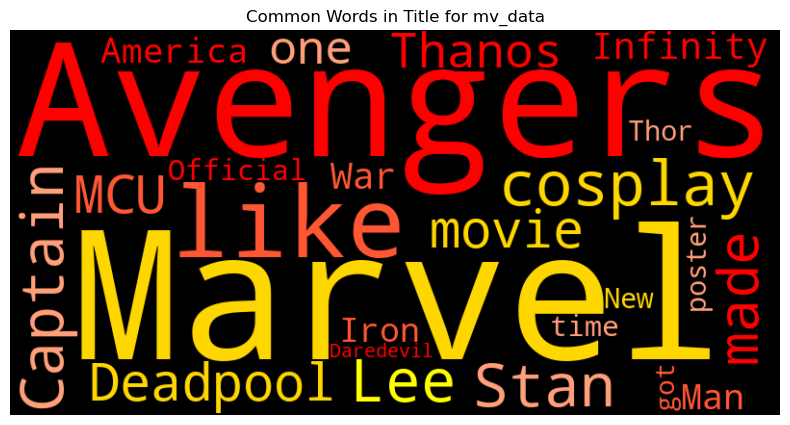

In [164]:
mv_data['title'] = mv_data['title'].fillna('')

# Tokenize the text into words
mv_data['title_words'] = mv_data['title'].apply(nltk.word_tokenize)

# Get the NLTK stop words list
stop_words = set(stopwords.words('english'))

# Function to filter out stop words and non-alphabetical words
def filter_words(text):
    return [word for word in text if word.isalpha() and word.lower() not in stop_words]

# Apply the filtering function to titles
mv_data['title_words'] = mv_data['title_words'].apply(filter_words)

# Flatten the list of title words
all_title_words = [word for sublist in mv_data['title_words'] for word in sublist]
title_word_counts = Counter(all_title_words)

# Find the most common words (adjust the number as needed)
num_common_words = 25
most_common_title_words = title_word_counts.most_common(num_common_words)

# Convert the most common words to a DataFrame for easy viewing
num_common_words_df = pd.DataFrame(most_common_title_words, columns=['Word', 'Frequency'])
print(num_common_words_df)

def generate_word_cloud(word_counts, title):
    def random_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        # Define a list of color choices
        colors = ["#FF0000", "#FF5733", "#FFA07A", "#FFD700", "#FFFF00"]
        return random.choice(colors)

    wordcloud = WordCloud(width=800, height=400, background_color='black', color_func=random_color_func).generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_word_cloud(dict(most_common_title_words), "Common Words in Title for mv_data")

         Word  Frequency
0       great          3
1        know          2
2         god          2
3        find          2
4       every          2
5       think          2
6        else          2
7       still          1
8      hoping          1
9        give          1
10       sets          1
11  abilities          1
12    satisfy          1
13       fans          1
14    someday          1
15     Seeing          1
16      Luffy          1
17    stretch          1
18     Kamala          1
19     energy          1
20      stuff          1
21      kills          1
22      least          1
23       done          1
24      swear          1


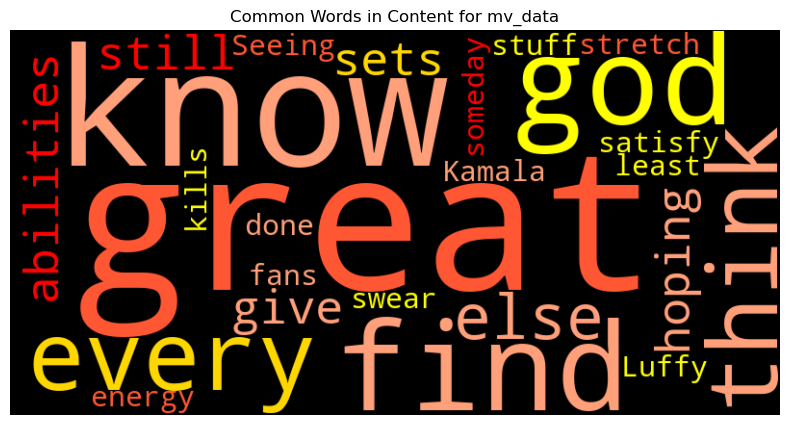

In [165]:
mv_data['content'] = mv_data['content'].fillna('')
mv_data['content_words'] = mv_data['content'].apply(nltk.word_tokenize)
mv_data['content_words'] = mv_data['content_words'].apply(filter_words)
all_content_words = [word for sublist in mv_data['content_words'] for word in sublist]
content_word_counts = Counter(all_content_words)

num_common_words = 25
most_common_content_words = content_word_counts.most_common(num_common_words)

num_common_content_words_df = pd.DataFrame(most_common_content_words, columns=['Word', 'Frequency'])
print(num_common_content_words_df)

generate_word_cloud(dict(most_common_content_words), "Common Words in Content for mv_data")

        Word  Frequency
0     Marvel         57
1   Avengers         44
2       like         43
3    cosplay         39
4       Stan         36
5        Lee         35
6    Captain         35
7       made         32
8        MCU         28
9   Deadpool         28
10     movie         28
11       one         27
12    Thanos         27
13  Infinity         26
14       War         26
15       Man         24
16   America         23
17      Iron         22
18  Official         21
19      time         21
20      know         21
21      Thor         20
22    poster         20
23       New         20
24       got         19


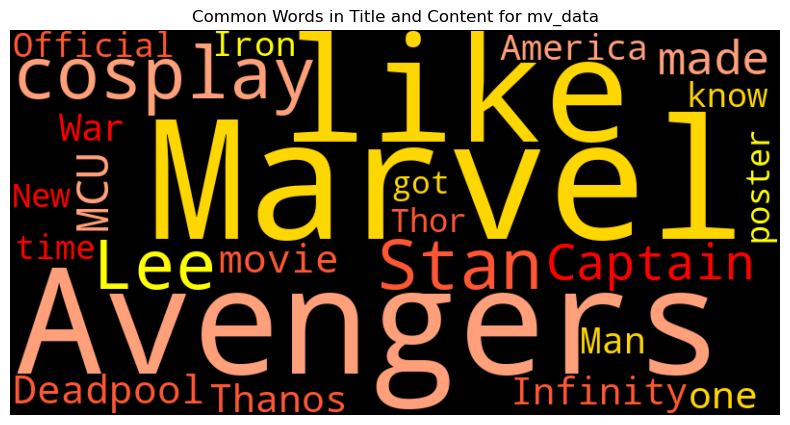

In [166]:
mv_data['text'] = mv_data['title'].fillna('') + " " + mv_data['content'].fillna('')
mv_data['words'] = mv_data['text'].apply(lambda text: [word for word in nltk.word_tokenize(text) if word.isalpha()])
all_words = [word for sublist in mv_data['words'] for word in sublist]
filtered_words = [word for word in all_words if word.lower() not in stop_words]
word_counts = Counter(filtered_words)
num_common_words = 25
most_common_words = word_counts.most_common(num_common_words)
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
print(common_words_df)

generate_word_cloud(dict(most_common_words), "Common Words in Title and Content for mv_data")


In [167]:
data = {
    'Word': ['Marvel', 'Avengers', 'like', 'cosplay', 'Stan', 'Lee', 'Captain', 'made', 'MCU', 'Deadpool', 'movie', 'one', 'Thanos', 'Infinity', 'War', 'Man', 'America', 'Iron', 'Official', 'time', 'know', 'Thor', 'poster', 'New', 'got'],
    'Frequency': [57, 44, 43, 39, 36, 35, 35, 32, 28, 28, 28, 27, 27, 26, 26, 24, 23, 22, 21, 21, 21, 20, 20, 20, 19]
}

df = pd.DataFrame(data)

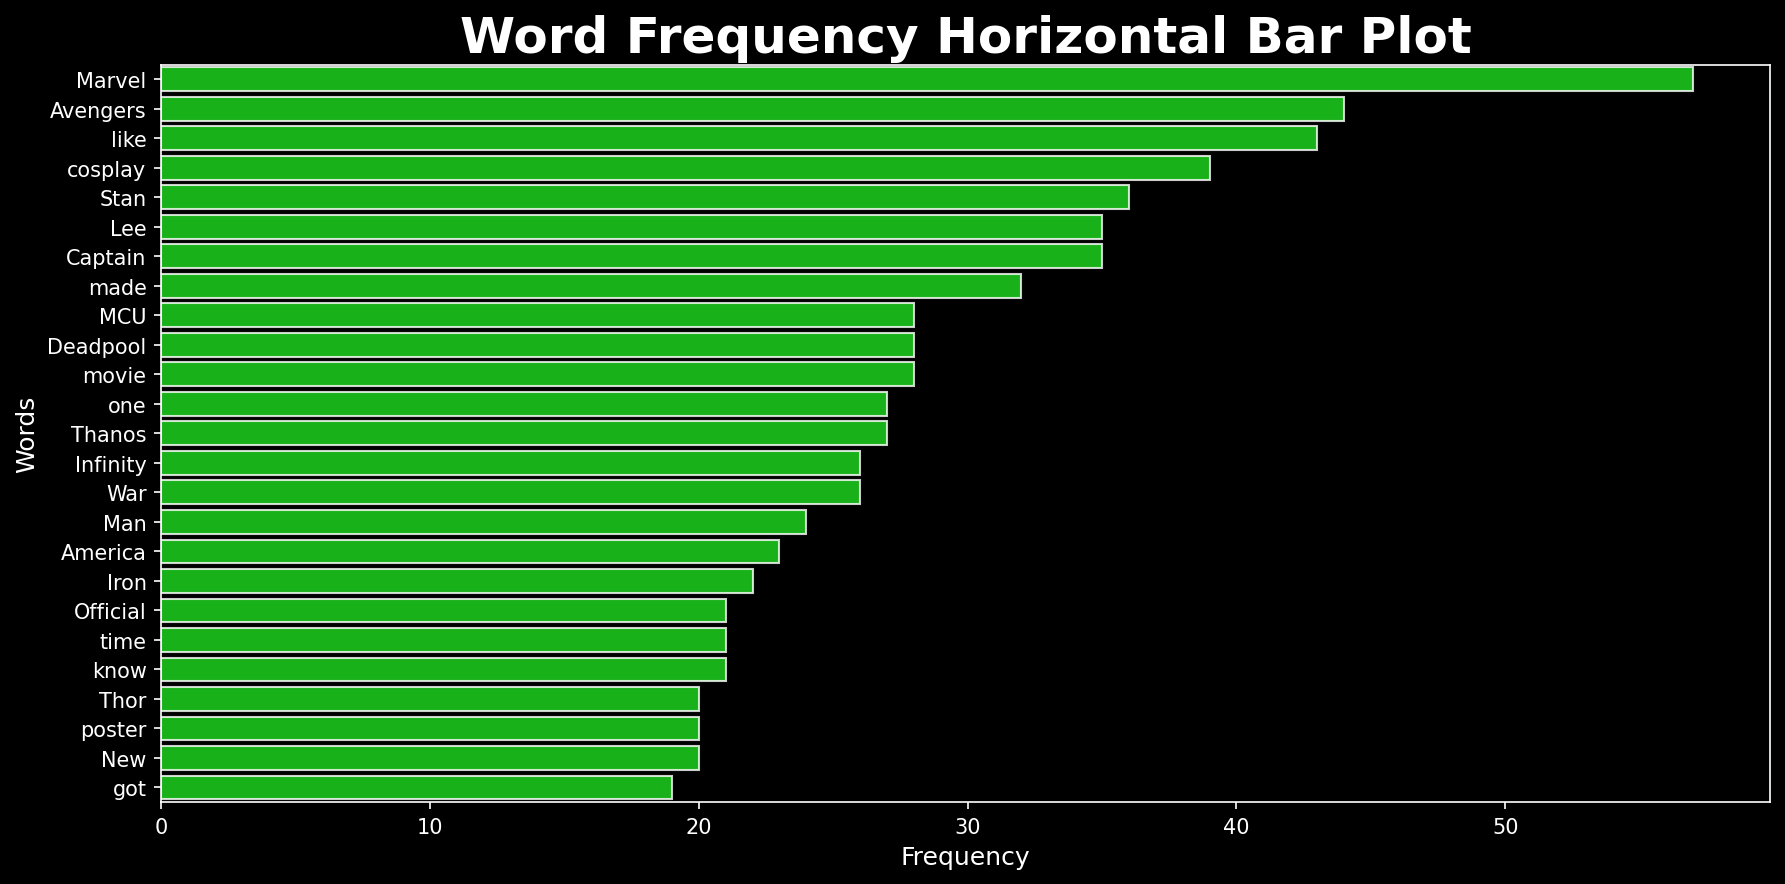

In [168]:
df = df[::-1]

# Create a horizontal bar plot with custom styling
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), dpi=150, facecolor='black')
plt.title('Word Frequency Horizontal Bar Plot', fontsize=24, fontweight='bold', color='white')

# Set the color palette and make the bars transparent
sns.set_palette(neon_palette)
sns.barplot(data=df, y='Word', x='Frequency', color='lime', alpha=0.8, edgecolor='white')

plt.xlabel('Frequency', fontsize=12, color='white')
plt.ylabel('Words', fontsize=12, color='white')
plt.gca().invert_yaxis() 

# Set the color of x and y axis labels to white
plt.xticks(color='white')
plt.yticks(color='white')
axes.tick_params(axis='x', colors='white')
axes.tick_params(axis='y', colors='white')

# Change background grid to black and lines to white
axes.set_facecolor('black')
for spine in axes.spines.values():
    spine.set_edgecolor('white')

# Automatically adjust subplot layout
plt.tight_layout()
plt.show()


In [169]:
hp_data = harrypotter[['title', 'content']].copy()

In [170]:
hp_data.head()

,title,content
0,How to make a grown man cry: Hagrid Edition.,NaN
1,Warwick Davis and his various roles in Harry P...,NaN
2,After waiting nearly 2 months for my missing p...,NaN
3,Another dungbomb from my pensive,NaN
4,I made a model of Azkaban,NaN


In [171]:
hp_data['subreddit'] = 'Harry Potter'

In [172]:
hp_data.head()

,title,content,subreddit
0,How to make a grown man cry: Hagrid Edition.,NaN,Harry Potter
1,Warwick Davis and his various roles in Harry P...,NaN,Harry Potter
2,After waiting nearly 2 months for my missing p...,NaN,Harry Potter
3,Another dungbomb from my pensive,NaN,Harry Potter
4,I made a model of Azkaban,NaN,Harry Potter


         Word  Frequency
0       Harry        157
1      Potter        104
2    Hogwarts         52
3        made         36
4         one         31
5        like         30
6    Hermione         26
7        love         24
8        year         23
9     thought         20
10       know         20
11      years         20
12      movie         20
13       time         20
14      would         19
15      books         19
16     movies         19
17      first         19
18    Weasley         17
19        Ron         17
20  Voldemort         17
21      think         16
22      Snape         16
23      Happy         16
24     Hagrid         15


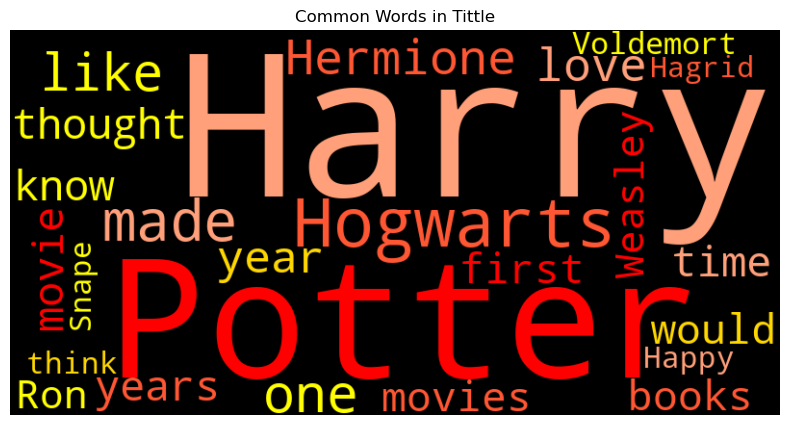

In [173]:
hp_data['title'] = hp_data['title'].fillna('')
hp_data['title_words'] = hp_data['title'].apply(nltk.word_tokenize)
hp_data['title_words'] = hp_data['title_words'].apply(filter_words)
all_title_words = [word for sublist in hp_data['title_words'] for word in sublist]
title_word_counts = Counter(all_title_words)

num_common_words = 25
most_common_title_words = title_word_counts.most_common(num_common_words)

num_common_words_df = pd.DataFrame(most_common_title_words, columns=['Word', 'Frequency'])
print(num_common_words_df)

generate_word_cloud(dict(most_common_title_words), "Common Words in Tittle")

          Word  Frequency
0        Harry         50
1    Voldemort         18
2        would         14
3   Dumbledore         12
4         like         11
5          one         10
6      thought         10
7        never          9
8       really          9
9        could          9
10      movies          8
11       first          8
12        told          8
13       Snape          8
14      series          7
15   something          7
16        kind          7
17        know          7
18       https          7
19      Potter          7
20      people          7
21         Ron          7
22        much          6
23        book          6
24      Arthur          6


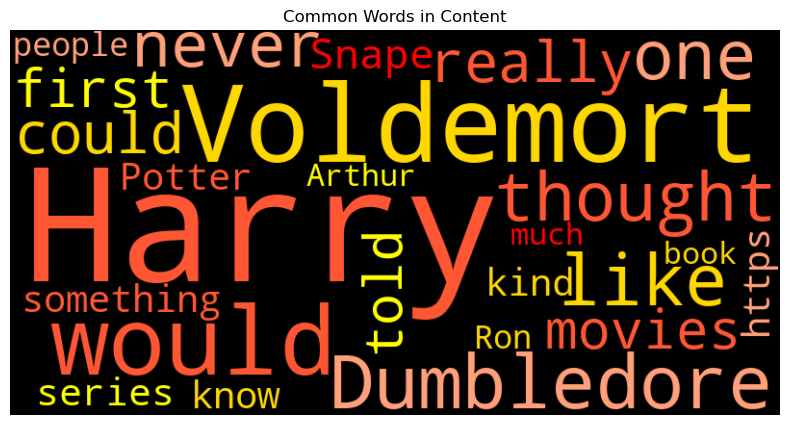

In [174]:
hp_data['content'] = hp_data['content'].fillna('')
hp_data['content_words'] = hp_data['content'].apply(nltk.word_tokenize)
hp_data['content_words'] = hp_data['content_words'].apply(filter_words)
all_content_words = [word for sublist in hp_data['content_words'] for word in sublist]
content_word_counts = Counter(all_content_words)

num_common_words =25
most_common_content_words = content_word_counts.most_common(num_common_words)

num_common_content_words_df = pd.DataFrame(most_common_content_words, columns=['Word', 'Frequency'])
print(num_common_content_words_df)

generate_word_cloud(dict(most_common_content_words), "Common Words in Content")

          Word  Frequency
0        Harry        207
1       Potter        111
2     Hogwarts         55
3         like         41
4          one         41
5         made         40
6    Voldemort         35
7        would         33
8      thought         30
9         love         28
10        know         27
11    Hermione         27
12      movies         27
13       first         27
14  Dumbledore         26
15        year         25
16        time         25
17       years         24
18       Snape         24
19         Ron         24
20      really         22
21     Weasley         22
22      series         22
23       movie         22
24       books         20


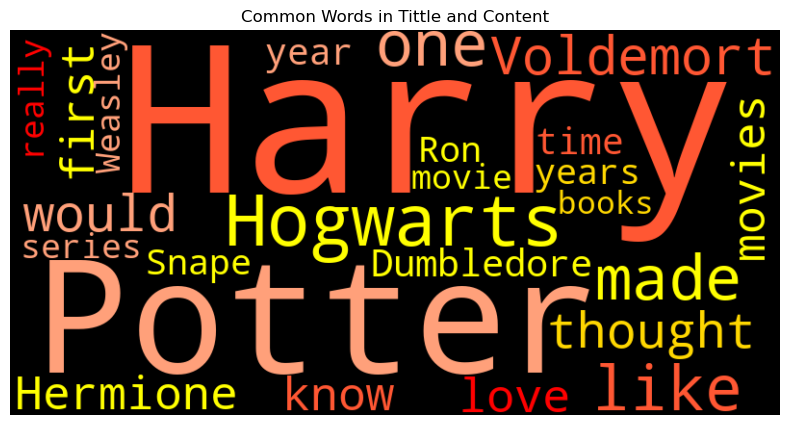

In [175]:
hp_data['text'] = hp_data['title'].fillna('') + " " + hp_data['content'].fillna('')
hp_data['words'] = hp_data['text'].apply(lambda text: [word for word in nltk.word_tokenize(text) if word.isalpha()])
all_words = [word for sublist in hp_data['words'] for word in sublist]
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word.lower() not in stop_words]
word_counts = Counter(filtered_words)
num_common_words = 25
most_common_words = word_counts.most_common(num_common_words)
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
print(common_words_df)

generate_word_cloud(dict(most_common_words), "Common Words in Tittle and Content")

In [176]:
data = {
    'Word': ['Harry', 'Potter', 'Hogwarts', 'like', 'one', 'made', 'Voldemort', 'would', 'thought', 'love', 'know', 'Hermione', 'movies', 'first', 'Dumbledore', 'year', 'time', 'years', 'Snape', 'Ron', 'really', 'Weasley', 'series', 'movie', 'books'],
    'Frequency': [207, 111, 55, 41, 41, 40, 35, 33, 30, 28, 27, 27, 27, 27, 26, 25, 25, 24, 24, 24, 22, 22, 22, 22, 20]
}

df = pd.DataFrame(data)


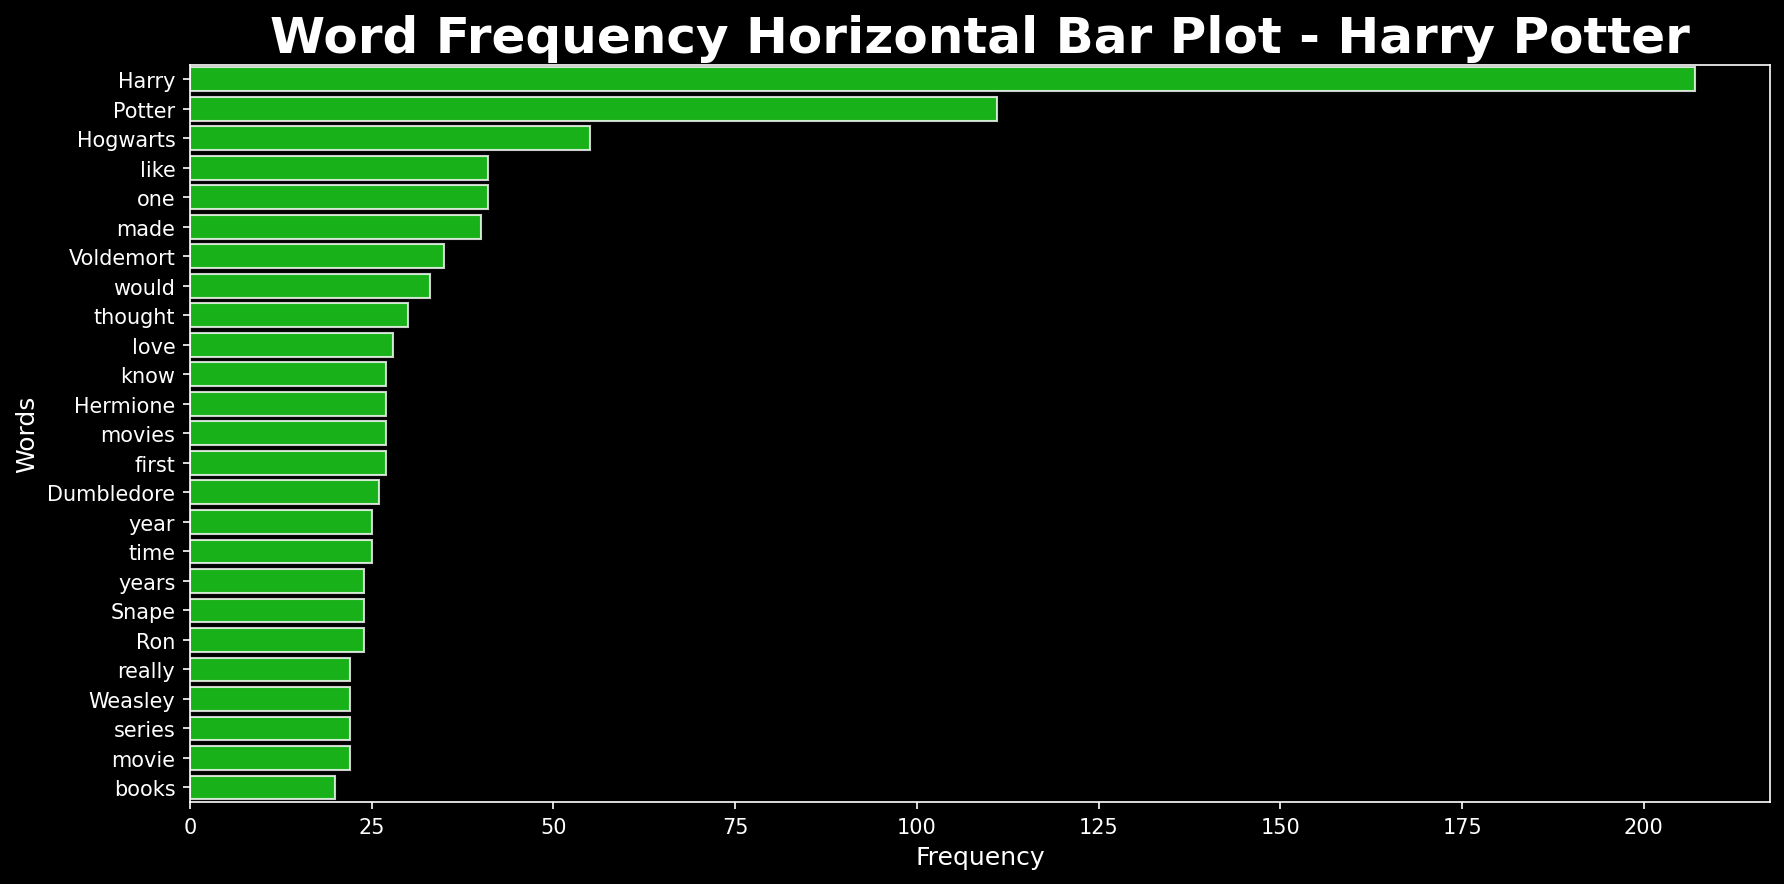

In [177]:
df = df[::-1]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), dpi=150, facecolor='black')
plt.title('Word Frequency Horizontal Bar Plot - Harry Potter', fontsize=24, fontweight='bold', color='white')

sns.set_palette(neon_palette)
sns.barplot(data=df, y='Word', x='Frequency', color='lime', alpha=0.8, edgecolor='white')

plt.xlabel('Frequency', fontsize=12, color='white')
plt.ylabel('Words', fontsize=12, color='white')
plt.gca().invert_yaxis() 

plt.xticks(color='white')
plt.yticks(color='white')
axes.tick_params(axis='x', colors='white')
axes.tick_params(axis='y', colors='white')

axes.set_facecolor('black')
for spine in axes.spines.values():
    spine.set_edgecolor('white')
    
plt.tight_layout()
plt.show()

## Comine Data

In [178]:
mv_hp = pd.concat([mv_data, hp_data], ignore_index=True)

In [179]:
mv_hp.reset_index(drop=True, inplace=True)

In [180]:
mv_hp.head()

,title,content,subreddit,title_words,content_words,text,words
0,We need more scenes like this,,Marvel,"[need, scenes, like]",[],We need more scenes like this,"[We, need, more, scenes, like, this]"
1,Fun in the sun with Dr. Strange,,Marvel,"[Fun, sun, Dr, Strange]",[],Fun in the sun with Dr. Strange,"[Fun, in, the, sun, with, Dr, Strange]"
2,Neat,,Marvel,[Neat],[],Neat,[Neat]
3,My Son's Graduation Mortarboard,,Marvel,"[Son, Graduation, Mortarboard]",[],My Son's Graduation Mortarboard,"[My, Son, Graduation, Mortarboard]"
4,Chris Evans being great as usual,,Marvel,"[Chris, Evans, great, usual]",[],Chris Evans being great as usual,"[Chris, Evans, being, great, as, usual]"


### Logistic Regression Model

In [185]:
X = mv_hp['words'].apply(lambda words: ' '.join(words))
y = mv_hp['subreddit']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize and train the logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)

# Calculate cross-validation scores, training score, and testing score
cross_val_scores = cross_val_score(classifier, X_train_tfidf, y_train, cv=5)
training_score = classifier.score(X_train_tfidf, y_train)
testing_score = classifier.score(X_test_tfidf, y_test)

# Print the results
print("Cross-Validation Scores:", cross_val_scores)
print("Mean CV Score:", cross_val_scores.mean())
print("Training Score:", training_score)
print("Testing Score:", testing_score)

# Make predictions and evaluate the model
y_pred = classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print(report)

Cross-Validation Scores: [0.771875 0.80625  0.815625 0.815625 0.80625 ]
Mean CV Score: 0.803125
Training Score: 0.90875
Testing Score: 0.825
Accuracy: 0.825
              precision    recall  f1-score   support

Harry Potter       0.80      0.87      0.83       201
      Marvel       0.86      0.78      0.82       199

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



I used a logistic regression model to predict whether a piece of text is related to "Harry Potter" or "Marvel." Here's how the model performed:

- Cross-Validation Scores: The cross-validation scores represent how well the model generalizes to unseen data. I obtained scores of approximately 0.772, 0.806, 0.816, 0.816, and 0.806 in each of the five cross-validation folds. The mean cross-validation score is about 0.803. These scores indicate that the model consistently performs well on different subsets of the training data.
- Training Score: The training score tells me how well the model fits the training data. In my case, the training score is 0.909, meaning the model correctly predicted 90.9% of the training data instances.
- Testing Score: The testing score, which is 0.825, shows how well the model generalizes to unseen data. It means that I correctly predicted 82.5% of the instances in my testing dataset.
- Accuracy: The overall accuracy of the model is 0.825, indicating that 82.5% of the instances were correctly classified.
- Precision, Recall, and F1-Score: The precision measures the proportion of positive predictions that were correct, and recall measures the proportion of actual positive instances that were correctly predicted. For the "Harry Potter" class, the precision is 0.80, and the recall is 0.87, resulting in an F1-score of 0.83. For the "Marvel" class, the precision is 0.86, the recall is 0.78, and the F1-score is 0.82.

In summary, this logistic regression model performs reasonably well with an accuracy of 0.825. It exhibits good precision and recall values for both classes. However, whether it's a "good" model depends on the specific requirements of the classification problem. The model may be considered good for many practical purposes, but further optimization or different models could be explored if higher accuracy is needed.

In [188]:
X_train = X_train.apply(lambda words: ' '.join(words))
X_test = X_test.apply(lambda words: ' '.join(words))

# Create a pipeline for TF-IDF vectorization and Naive Bayes classification
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the model on the training data
text_clf.fit(X_train, y_train)

# Predict the labels on the test data
y_pred = text_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Cross-validation
cross_val_scores = cross_val_score(text_clf, mv_hp['words'].apply(lambda words: ' '.join(words)), mv_hp['subreddit'], cv=5)
train_score = text_clf.score(X_train, y_train)
test_score = text_clf.score(X_test, y_test)

print(f"Accuracy: {accuracy}")
print(classification_rep)
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean CV Score: {cross_val_scores.mean()}")
print(f"Training Score: {train_score}")
print(f"Testing Score: {test_score}")

Accuracy: 0.8
              precision    recall  f1-score   support

Harry Potter       0.79      0.83      0.81       201
      Marvel       0.81      0.77      0.79       199

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400

Cross-Validation Scores: [0.8175 0.8125 0.84   0.8325 0.845 ]
Mean CV Score: 0.8295
Training Score: 0.94625
Testing Score: 0.8


In this text classification task using the Naive Bayes classifier and TF-IDF vectorization on the combined dataset of Harry Potter and Marvel subreddits, I achieved the following results:

- Accuracy: The accuracy of the model is 0.80, meaning that it correctly predicted 80% of the instances. This demonstrates that the model performs reasonably well in distinguishing between the two subreddits.
- Precision: For the "Harry Potter" class, the precision is 0.79, which indicates that 79% of the instances predicted as "Harry Potter" were accurate. Similarly, for the "Marvel" class, the precision is 0.81, meaning that 81% of the instances predicted as "Marvel" were correct.
- Recall: The recall for "Harry Potter" is 0.83, suggesting that the model correctly identified 83% of the actual "Harry Potter" instances. For "Marvel," the recall is 0.77, indicating that 77% of the actual "Marvel" instances were correctly predicted.
- F1-Score: The F1-scores provide a balance between precision and recall. For "Harry Potter," the F1-score is 0.81, and for "Marvel," it is 0.79.
- Cross-Validation Scores: The model's performance was consistent across five cross-validation folds. The cross-validation scores ranged from 0.8125 to 0.845, with a mean score of 0.8295. This suggests that the model generalizes well to unseen data.
- Training Score: The model achieved a high training score of 0.94625, indicating that it fit the training data very well.
- Testing Score: The testing score is 0.80, which is consistent with the accuracy score. It shows that the model's performance on the testing data is also quite good.

Overall, based on these results, I can conclude that the Naive Bayes classifier with TF-IDF vectorization is a reasonably good model for distinguishing between the "Harry Potter" and "Marvel" subreddits.

**TF-IDF Vectorization (Term Frequency-Inverse Document Frequency):**

- TF-IDF is a numerical statistic used to reflect the importance of a word in a document relative to a collection of documents (corpus).
- It assigns a weight to each word in a document based on how frequently it appears in the document (term frequency) and how rare or common it is in the entire corpus (inverse document frequency).
- This transformer was used in the logistic regression analysis and multinomial Naive Bayes analysis.

### Conclusion: Model

After comparing the results from both the MultinomialNB (Naive Bayes) model and the Logistic Regression model for classifying text data from the combined "Harry Potter" and "Marvel" subreddits, it's evident that the Logistic Regression model outperforms the MultinomialNB model in several aspects.

The Logistic Regression model achieved a slightly higher accuracy of 0.825 compared to the MultinomialNB model's accuracy of 0.8. This indicates that the Logistic Regression model correctly predicted a greater percentage of instances. In terms of precision and recall, the Logistic Regression model also demonstrated superior performance for both "Harry Potter" and "Marvel" classes, with higher precision and recall values.

Furthermore, the F1-scores for both classes were marginally better with the Logistic Regression model, indicating a better balance between precision and recall.

In the case of cross-validation scores, the Logistic Regression model consistently showed higher scores across different folds, resulting in a higher mean cross-validation score of 0.8295. This suggests that the Logistic Regression model generalizes well to unseen data.

Although both models performed reasonably well, the results clearly indicate that the Logistic Regression model is the better choice for this text classification task, as it exhibits higher accuracy, precision, recall, F1-scores, and cross-validation performance.

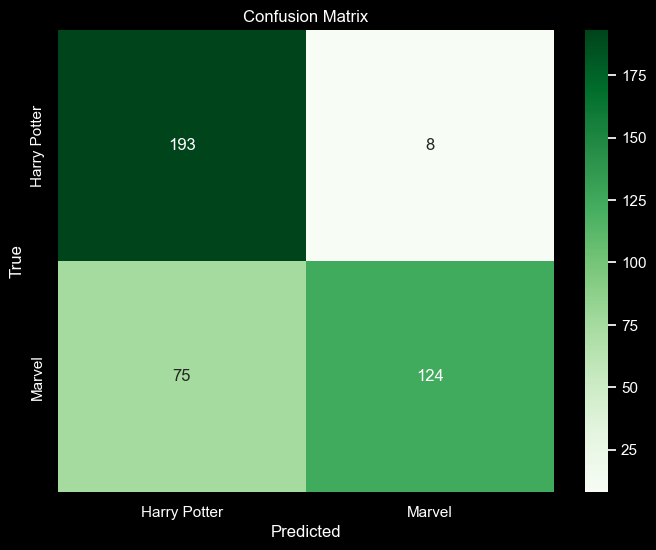

In [213]:
confusion = confusion_matrix(y_test, classifier.predict(X_test_tfidf))

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Greens', xticklabels=['Harry Potter', 'Marvel'], yticklabels=['Harry Potter', 'Marvel'])
plt.xlabel('Predicted', color='white') 
plt.ylabel('True', color='white') 
plt.title('Confusion Matrix', color='white')  

ax = plt.gca()
ax.set_facecolor('black') 

plt.show()

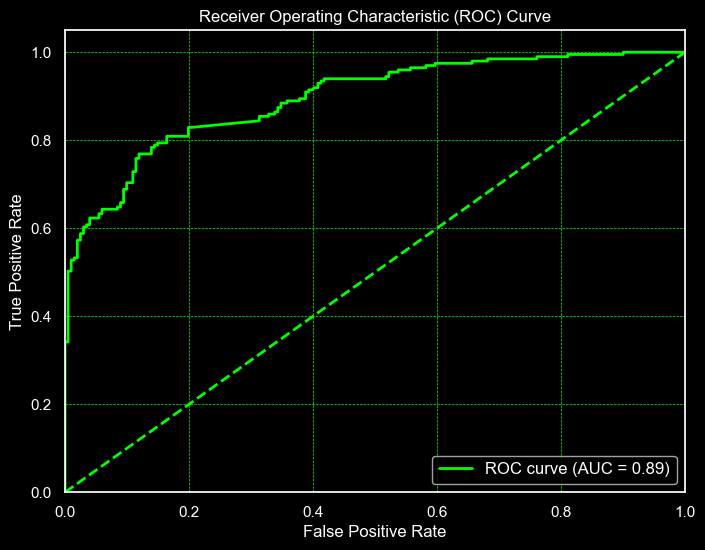

In [212]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Create binary labels for the "Marvel" class
y_test_binary = (y_test == 'Marvel').astype(int)

# Get the predicted probabilities for the positive class (class 1)
y_probs = classifier.predict_proba(X_test_tfidf)[:, 1]

# Calculate the ROC curve for binary classification
fpr, tpr, thresholds = roc_curve(y_test_binary, y_probs)
roc_auc = auc(fpr, tpr)

# Set the figure and axis styles
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('black')  # Set the entire figure background to black
ax.set_facecolor('black')  # Set the axis background to black
plt.plot([0, 1], [0, 1], color='lime', lw=2, linestyle='--')

# Plot the ROC curve with lime color
plt.plot(fpr, tpr, color='lime', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Customize labels and title with white color
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.title('Receiver Operating Characteristic (ROC) Curve', color='white')

# Customize legend with white color
plt.legend(loc='lower right', fontsize=12, labelcolor='white')

# Add gridlines with lime color
ax.grid(color='lime', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()
